# Transformers and Text Processing

## 1.  Sentiment Analysis with Transformers

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
import torch

In [3]:
from transformers import pipeline

In [6]:
INPUT_DATA = "../data/airline_tweets.csv"

In [7]:
raw = pd.read_csv(INPUT_DATA)
raw.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


In [8]:
df = raw[['airline_sentiment', 'text']]

In [9]:
df.head(5)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [10]:
df.isna().sum()

airline_sentiment    0
text                 0
dtype: int64

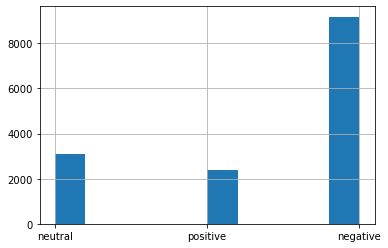

In [11]:
df.airline_sentiment.hist()

In [12]:
classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [13]:
s1 = "This is a great book"
s2 = "We did not enjoy the movie at all"

In [14]:
classifier(s1)

[{'label': 'POSITIVE', 'score': 0.999872088432312}]

In [15]:
classifier(s2)

[{'label': 'NEGATIVE', 'score': 0.9993563294410706}]

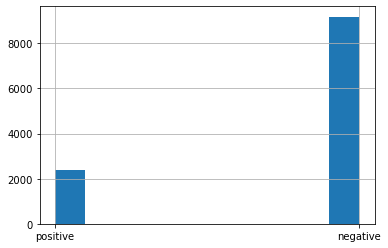

In [16]:
df = df[df.airline_sentiment != 'neutral']
df.airline_sentiment.hist()

In [17]:
df.shape

(11541, 2)

In [18]:
df.head(2)

,airline_sentiment,text
1,positive,@VirginAmerica plus you've added commercials t...
3,negative,@VirginAmerica it's really aggressive to blast...


In [19]:
predictions = classifier(df.text.tolist())

In [20]:
predictions[:8]

[{'label': 'POSITIVE', 'score': 0.6070873737335205},
 {'label': 'NEGATIVE', 'score': 0.9973449110984802},
 {'label': 'NEGATIVE', 'score': 0.9995823502540588},
 {'label': 'NEGATIVE', 'score': 0.9854251742362976},
 {'label': 'POSITIVE', 'score': 0.9553210139274597},
 {'label': 'POSITIVE', 'score': 0.9827088117599487},
 {'label': 'POSITIVE', 'score': 0.9994851350784302},
 {'label': 'POSITIVE', 'score': 0.9993509650230408}]

## Evaluate how good the "model" is

In [21]:
probs = [ p['score'] if p['label'].startswith('P') else (1 - p['score']) for p in predictions ]

In [22]:
probs[:8]

[0.6070873737335205,
 0.0026550889015197754,
 0.0004176497459411621,
 0.014574825763702393,
 0.9553210139274597,
 0.9827088117599487,
 0.9994851350784302,
 0.9993509650230408]

In [23]:
preds = [1 if p['label'].startswith('P') else 0 for p in predictions]

In [24]:
preds[:8]

[1, 0, 0, 0, 1, 1, 1, 1]

In [25]:
df.airline_sentiment.head(2)

1    positive
3    negative
Name: airline_sentiment, dtype: object

In [28]:
# map 'positive' to 1 and 'negative' to 0
sentiment_map = {'positive': 1, 'negative': 0}

df['target'] = df['airline_sentiment'].map(sentiment_map)
df.head(5)

<ipython-input-28-9845a14285ae>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = df['airline_sentiment'].map(sentiment_map)


,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [29]:
# What's the accuracy of our model compare to the "golden truth": column 'airline_sentiment'

np.mean(df['target'] == preds)

0.8898708950697514

In [30]:
cm = confusion_matrix(df['target'], preds)

In [31]:
cm

array([[8271,  907],
       [ 364, 1999]])

In [32]:
f1_score(df['target'], preds)

0.7587777566900741

In [33]:
roc_auc_score(df['target'], probs)

0.948593515174145

## Text Generation with HuggingFace

In [34]:
from pprint import pprint

In [35]:
text_transformer = pipeline('text-generation', model='gpt2')

In [37]:
output = text_transformer("Transformers are neural networks with attention have been used with great success recently",
                          max_length=100,
                          pad_token_id=50256)

In [39]:
output

[{'generated_text': 'Transformers are neural networks with attention have been used with great success recently and they offer interesting approaches. However, their application has been limited by the limitations of previous models and computational complexity. A good review of these issues can be obtained in this post.'}]

In [41]:
pprint(output[0]['generated_text'])

('Transformers are neural networks with attention have been used with great '
 'success recently and they offer interesting approaches. However, their '
 'application has been limited by the limitations of previous models and '
 'computational complexity. A good review of these issues can be obtained in '
 'this post.')


In [42]:
prompt = """
Transformers are neural networks with attention have been used with great success recently
"""

output = text_transformer(prompt,
                          max_length=100,
                          num_return_sequences=5,
                          pad_token_id=50256)

In [43]:
len(output)

5

In [44]:
output

[{'generated_text': "\nTransformers are neural networks with attention have been used with great success recently\n\nThis new study examines the performance of a specific task, and compares the performance of those who perform the task and those who don't (with those who performed it without processing it). The findings show different results and the differences (in terms of neural processing time and latency) between tasks are not significant. This study was carried out as part of a larger investigation within the Neuropsychiatry and Behavior group at the N"},
 {'generated_text': '\nTransformers are neural networks with attention have been used with great success recently\n\nThe neural network that makes the difference between the real world and the real world has an astonishing speed, but it uses only one type of word and word recognition.\n\nThe network is called "revised-image" for short, because it is able to detect those moments of the image when the word has a better chance of f

In [45]:
pprint(output)

[{'generated_text': '\n'
                    'Transformers are neural networks with attention have been '
                    'used with great success recently\n'
                    '\n'
                    'This new study examines the performance of a specific '
                    'task, and compares the performance of those who perform '
                    "the task and those who don't (with those who performed it "
                    'without processing it). The findings show different '
                    'results and the differences (in terms of neural '
                    'processing time and latency) between tasks are not '
                    'significant. This study was carried out as part of a '
                    'larger investigation within the Neuropsychiatry and '
                    'Behavior group at the N'},
 {'generated_text': '\n'
                    'Transformers are neural networks with attention have been '
                    'used with great success recen

In [46]:
FROST_FILENAME = "../data/robert_frost.txt"

frost_lines = []
with open(FROST_FILENAME, "r") as file:
    frost_lines = file.readlines()
    frost_lines = [line.rstrip() for line in frost_lines if len(line) > 0]


In [47]:
frost_lines[:5]

['Two roads diverged in a yellow wood,',
 'And sorry I could not travel both',
 'And be one traveler, long I stood',
 'And looked down one as far as I could',
 'To where it bent in the undergrowth;']

In [50]:
poetry = text_transformer(frost_lines[0], num_return_sequences=3, max_new_tokens=30, pad_token_id=50256)

In [51]:
pprint(poetry)

[{'generated_text': 'Two roads diverged in a yellow wood, with the river below '
                    'me in the center. My hand was crossed by a long red '
                    'trail, which I made to ascend toward the city while '
                    'others went'},
 {'generated_text': 'Two roads diverged in a yellow wood, there were four '
                    'tracks and there were four crossings and we were all in '
                    'an area for an hour, and there, we all waited until we '
                    'got there'},
 {'generated_text': 'Two roads diverged in a yellow wood, the road leading '
                    "into the street where the police's vehicle had landed.\n"
                    '\n'
                    'Police used their weapons against the parked vehicle '
                    'after its crash and it was'}]
